In [32]:
import numpy as np
from skimage import io, color, data
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import sys
%matplotlib inline

In [112]:
img1 = cv2.imread("image1.jpg") #baseball
img1 = cv2.resize(img1, (1000, 1000))
img2 = cv2.imread("image2.jpg") #tennis ball
img2 = cv2.resize(img2, (1000, 1000))

In [103]:
def convolve(image, kernel):
    output = np.zeros_like(image)
    #kernel = np.flipud(np.fliplr(kernel))
    padded_img = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    padded_img[1:-1, 1:-1] = image 
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[y,x]=(kernel*padded_img[y:y+3,x:x+3]).sum()    
    return output

In [104]:
def reduce(image):
    hkernel = np.array([1,2,1]) # gaussian blur
    vkernel = np.array([[1],[2],[1]])
    output = np.zeros((int(image.shape[0]/2), int(image.shape[1]/2)))
    img = np.zeros_like(image)
    img = convolve(image, hkernel)
    img = convolve(img, vkernel)    
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[int(y/2),int(x/2)] = img[y, x]     
    return output   

In [105]:
def expand(image):    
    output = np.repeat(image, 2, axis=1)
    output = np.repeat(output, 2, axis=0)
    return output

In [106]:
def reduceDim(img):
    if(img.shape[0] % 2):
        img = np.delete(img, 1, 0)
    if(img.shape[1] % 2):
        img = np.delete(img, 0, 1)
    return img

In [107]:
def gaussianPyramid(image, n):
    images = []
    image = reduceDim(image)
    images.append(image)
    for i in range(n-1):
        image = reduceDim(image)
        image = reduce(image)
        #image = reduceDim(image)
        images.append(image)
    return images

In [108]:
def laplacianPyramid(img, n):
    layer = img.copy()
    gaussian_pyramid = [layer]
    for i in range(n):
        layer = cv2.pyrDown(layer)
        gaussian_pyramid.append(layer)
    layer = gaussian_pyramid[n-1]
    laplacian_pyramid = [layer]
    for i in range(n-1, 0, -1):
        size = (gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid

In [109]:
def combine(lap1, lap2):
    basetennis = []
    n = 0
    for img1_lap, img2_lap in zip(lap1, lap2):
        n += 1
        cols, rows, ch = img1_lap.shape
        laplacian = np.hstack((img1_lap[:, 0:int(cols/2)], img2_lap[:, int(cols/2):]))
        basetennis.append(laplacian)
    return basetennis

In [110]:
def reconstruct(li, n):
    reconstructed_image = li[0]
    for i in range(1, n):
        size = (li[i].shape[1], li[i].shape[0])
        reconstructed_image = cv2.pyrUp(reconstructed_image, dstsize=size)
        reconstructed_image = cv2.add(reconstructed_image, li[i])   
    return reconstructed_image

In [88]:
img = io.imread('baseball.jpg')
img = color.rgb2gray(img)
if(img.shape[0] % 2):
    img = np.delete(img, 1, 0)
if(img.shape[1] % 2):
    img = np.delete(img, 0, 1)
img.shape

(224, 224)

/Users/Vineeth/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


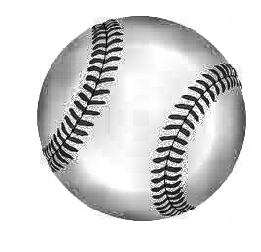

In [89]:
image_equalized = exposure.equalize_adapthist(img/np.max(np.abs(img)), clip_limit=0.03)
plt.imshow(image_equalized, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [114]:
kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
kernel = np.array([[1,2,1],[2,4,2],[1,2,1]]) # gaussian blur
blurred_img = convolve(img, kernel)

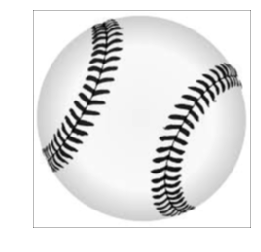

In [115]:
plt.imshow(blurred_img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [116]:
reduced_img = reduce(img)

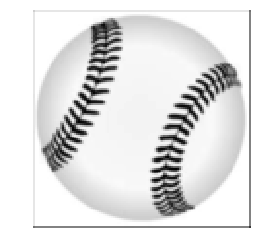

In [119]:
cv2.imwrite("blurred_img.jpg", reduced_img)
plt.imshow(reduced_img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [94]:
reduced_img.shape

(112, 112)

In [95]:
img.shape

(224, 224)

In [96]:
expanded_img = expand(reduced_img)

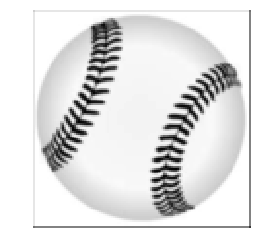

In [120]:
cv2.imwrite("expanded_img.jpg", expanded_img)
plt.imshow(expanded_img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [98]:
img.shape

(224, 224)

In [99]:
expanded_img.shape

(224, 224)

In [100]:
images = gaussianPyramid(img, 3)

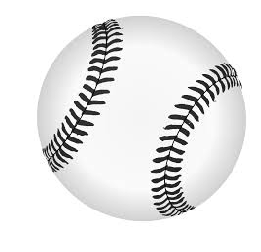

(224, 224)


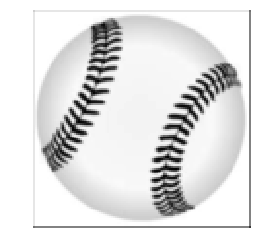

(112, 112)


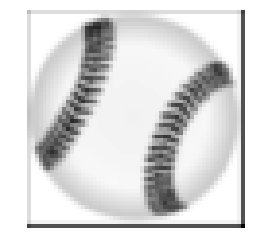

(56, 56)


In [122]:
for i in images:
    count += 1
    plt.imshow(i, cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()
    print(i.shape)

In [123]:
lap1 = laplacianPyramid(img1, 3)
lap2 = laplacianPyramid(img2, 3)
reconstructed_img1 = reconstruct(lap1, 3)
cv2.imwrite("reconstructed_img1.jpg", reconstructed_img1)
reconstructed_img2 = reconstruct(lap2, 3)
cv2.imwrite("reconstructed_img2.jpg", reconstructed_img2)

True

In [85]:
#difference between original image and reconstructed image
diff = img2 - reconstructed_img2
np.sum(diff ** 2)

20523063

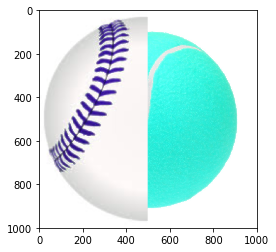

In [87]:
#blend two images of baseball and tennis ball
basetennis = combine(lap1, lap2)
reconstructed_img = reconstruct(basetennis, 3)
plt.imshow(reconstructed_img)
plt.show()

In [113]:
cv2.imwrite('image12.png',reconstructed_img)

True